# Bundesliga Analytics
### PySpark practice aiming to analyzes and answers the following questions:
1. Who are the winners of the D1 division in the Germany Football Association (Bundesliga) in the last decade?
2. Which teams have been relegated in the past 10 years?
3. What's the best month to watch Bundesliga? (based on last 10 seasons)
4. Does Octoberfest affect the performance of Bundesliga?
5. Which season of Bundesliga was the most competitive in the last decade?

In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
from pyspark.sql.window import Window
from pyspark.sql.functions import when, sum, max, rank, count, lead, avg

In [3]:
df_matches = spark.read.format('csv').options(header=True).load('bundesliga_data/Matches.csv')
df_matches = df_matches \
                .withColumn('Match_ID', df_matches.Match_ID.cast('int')) \
                .withColumn('Season', df_matches.Season.cast('int')) \
                .withColumn('FTHG', df_matches.FTHG.cast('int')) \
                .withColumn('FTAG', df_matches.FTAG.cast('int')) \
                .withColumnRenamed('FTHG', 'HomeGoals') \
                .withColumnRenamed('FTAG', 'AwayGoals') \
                .withColumnRenamed('FTR', 'MatchResult')
df_matches.show(5)

+--------+---+------+----------+-------------+--------------+---------+---------+-----------+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|HomeGoals|AwayGoals|MatchResult|
+--------+---+------+----------+-------------+--------------+---------+---------+-----------+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|        2|        1|          H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|        0|        1|          A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|        1|        1|          D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|        2|        1|          H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|        1|        3|          A|
+--------+---+------+----------+-------------+--------------+---------+---------+-----------+
only showing top 5 rows



In [4]:
df_teams = spark.read.format('csv').options(header=True).load('bundesliga_data/Teams.csv')
df_teams.show(5)

+------+-------------+---------+----------+------------------+----------------------+------------------+---------------+
|Season|     TeamName|KaderHome|AvgAgeHome|ForeignPlayersHome|OverallMarketValueHome|AvgMarketValueHome|StadiumCapacity|
+------+-------------+---------+----------+------------------+----------------------+------------------+---------------+
|  2017|Bayern Munich|       27|        26|                15|             597950000|          22150000|          75000|
|  2017|     Dortmund|       33|        25|                18|             416730000|          12630000|          81359|
|  2017|   Leverkusen|       31|        24|                15|             222600000|           7180000|          30210|
|  2017|   RB Leipzig|       30|        23|                15|             180130000|           6000000|          42959|
|  2017|   Schalke 04|       29|        24|                17|             179550000|           6190000|          62271|
+------+-------------+---------+

In [5]:
df_teams_in_matches = spark.read.format('csv').options(header=True).load('bundesliga_data/Teams_in_Matches.csv')
df_teams_in_matches.show(5)

+--------+--------------+
|Match_ID|Unique_Team_ID|
+--------+--------------+
|       1|            26|
|       1|            46|
|       2|            26|
|       2|            42|
|       3|            26|
+--------+--------------+
only showing top 5 rows



In [6]:
df_unique_teams = spark.read.format('csv').options(header=True).load('bundesliga_data/Unique_Teams.csv')
df_unique_teams.show(5)

+-------------+--------------+
|     TeamName|Unique_Team_ID|
+-------------+--------------+
|Bayern Munich|             1|
|     Dortmund|             2|
|   Leverkusen|             3|
|   RB Leipzig|             4|
|   Schalke 04|             5|
+-------------+--------------+
only showing top 5 rows



## 1. Who are the winners of the D1 division in the Germany Football Association (Bundesliga) in the last decade?

In [7]:
df_matches.show(10)

+--------+---+------+----------+--------------+--------------+---------+---------+-----------+
|Match_ID|Div|Season|      Date|      HomeTeam|      AwayTeam|HomeGoals|AwayGoals|MatchResult|
+--------+---+------+----------+--------------+--------------+---------+---------+-----------+
|       1| D2|  2009|2010-04-04|    Oberhausen|Kaiserslautern|        2|        1|          H|
|       2| D2|  2009|2009-11-01|   Munich 1860|Kaiserslautern|        0|        1|          A|
|       3| D2|  2009|2009-10-04| Frankfurt FSV|Kaiserslautern|        1|        1|          D|
|       4| D2|  2009|2010-02-21| Frankfurt FSV|     Karlsruhe|        2|        1|          H|
|       5| D2|  2009|2009-12-06|         Ahlen|     Karlsruhe|        1|        3|          A|
|       6| D2|  2009|2010-04-03|  Union Berlin|     Karlsruhe|        1|        1|          D|
|       7| D2|  2009|2009-08-14|     Paderborn|     Karlsruhe|        2|        0|          H|
|       8| D2|  2009|2010-03-08|     Bielefeld|   

In [8]:
df_D1_matches = df_matches.filter((df_matches['Div']=='D1') & ((df_matches['HomeGoals']>=0) & (df_matches['AwayGoals']>=0))) \
        .withColumn('HomePoint', 
                        when(df_matches['MatchResult'] == 'H', 3)
                        .when(df_matches['MatchResult'] == 'D', 1)
                        .otherwise(0)
                   ) \
        .withColumn('AwayPoint', 
                        when(df_matches['MatchResult'] == 'A', 3)
                        .when(df_matches['MatchResult'] == 'D', 1)
                        .otherwise(0)
                   ) \
        .withColumn('HomeWin', 
                        when(df_matches['MatchResult'] == 'H', 1)
                        .otherwise(0)
                   ) \
        .withColumn('AwayWin', 
                        when(df_matches['MatchResult'] == 'A', 1)
                        .otherwise(0)
                   ) \
        .withColumn('Draw', 
                        when(df_matches['MatchResult'] == 'D', 1)
                        .otherwise(0)
                   )

df_D1_matches.show(10)

+--------+---+------+----------+-------------+----------+---------+---------+-----------+---------+---------+-------+-------+----+
|Match_ID|Div|Season|      Date|     HomeTeam|  AwayTeam|HomeGoals|AwayGoals|MatchResult|HomePoint|AwayPoint|HomeWin|AwayWin|Draw|
+--------+---+------+----------+-------------+----------+---------+---------+-----------+---------+---------+-------+-------+----+
|      21| D1|  2009|2010-02-06|       Bochum|Leverkusen|        1|        1|          D|        1|        1|      0|      0|   1|
|      22| D1|  2009|2009-11-22|Bayern Munich|Leverkusen|        1|        1|          D|        1|        1|      0|      0|   1|
|      23| D1|  2009|2010-05-08|   M'gladbach|Leverkusen|        1|        1|          D|        1|        1|      0|      0|   1|
|      24| D1|  2009|2009-08-08|        Mainz|Leverkusen|        2|        2|          D|        1|        1|      0|      0|   1|
|      25| D1|  2009|2009-10-17|      Hamburg|Leverkusen|        0|        0|      

In [9]:
df_D1_season_summary = df_D1_matches.groupby('Season', 'HomeTeam') \
                .agg(
                        sum('HomePoint').alias('HomePointsPerSeason'),
                        sum('HomeGoals').alias('HGoalsFor'),
                        sum('AwayGoals').alias('HGoalsAgainst'),
                        sum('HomeWin').alias('HWins'),
                        sum('AwayWin').alias('HLoses'),
                        sum('Draw').alias('HDraw')
                    ) \
                .withColumnRenamed('HomeTeam','Team') \
                .join(
                    df_D1_matches.groupby('Season', 'AwayTeam') \
                    .agg(
                            sum('AwayPoint').alias('AwayPointsPerSeason'),
                            sum('HomeGoals').alias('AGoalsAgainst'),
                            sum('AwayGoals').alias('AGoalsFor'),
                            sum('HomeWin').alias('ALoses'),
                            sum('AwayWin').alias('AWins'),
                            sum('Draw').alias('ADraw')
                        ) \
                    .withColumnRenamed('AwayTeam','Team'),
                    ['Season', 'Team'],
                    'left'
                ) \
                .sort('Season')

df_D1_season_summary = df_D1_season_summary.withColumn('TotalPointsPerSeason', df_D1_season_summary['HomePointsPerSeason']+df_D1_season_summary['AwayPointsPerSeason']) \
                        .withColumn('GoalsFor', df_D1_season_summary['HGoalsFor']+df_D1_season_summary['AGoalsFor']) \
                        .withColumn('GoalsAgainst', df_D1_season_summary['HGoalsAgainst']+df_D1_season_summary['AGoalsAgainst']) \
                        .withColumn('Wins', df_D1_season_summary['HWins']+df_D1_season_summary['AWins']) \
                        .withColumn('Draws', df_D1_season_summary['HDraw']+df_D1_season_summary['ADraw']) \
                        .withColumn('Loses', df_D1_season_summary['HLoses']+df_D1_season_summary['ALoses'])

df_D1_season_summary = df_D1_season_summary.withColumn('GoalsDiff', df_D1_season_summary['GoalsFor']-df_D1_season_summary['GoalsAgainst']) \
                        .select('Season', 'Team', 'Wins', 'Draws', 'Loses', 'GoalsFor', 'GoalsAgainst', 'GoalsDiff', 'TotalPointsPerSeason')

df_D1_season_summary.show(10)

+------+--------------+----+-----+-----+--------+------------+---------+--------------------+
|Season|          Team|Wins|Draws|Loses|GoalsFor|GoalsAgainst|GoalsDiff|TotalPointsPerSeason|
+------+--------------+----+-----+-----+--------+------------+---------+--------------------+
|  1993|    M'Gladbach|  14|    7|   13|      65|          59|        6|                  49|
|  1993|     Stuttgart|  13|   11|   10|      51|          43|        8|                  50|
|  1993|       Dresden|  10|   14|   10|      33|          44|      -11|                  44|
|  1993|      Freiburg|  10|    8|   16|      54|          57|       -3|                  38|
|  1993|  Wattenscheid|   6|   11|   17|      48|          70|      -22|                  29|
|  1993|      Duisburg|  14|    8|   12|      41|          52|      -11|                  50|
|  1993| Werder Bremen|  13|   10|   11|      51|          44|        7|                  49|
|  1993|      Dortmund|  15|    9|   10|      49|          4

In [10]:
windowSpec  = Window.partitionBy('Season').orderBy(df_D1_season_summary['TotalPointsPerSeason'].desc(), df_D1_season_summary['GoalsDiff'].desc())

df_D1_season_summary = df_D1_season_summary.withColumn('Position', rank().over(windowSpec))

df_D1_season_summary.show(10)

+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+
|Season|          Team|Wins|Draws|Loses|GoalsFor|GoalsAgainst|GoalsDiff|TotalPointsPerSeason|Position|
+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+
|  1993| Bayern Munich|  17|   10|    7|      68|          37|       31|                  61|       1|
|  1993|Kaiserslautern|  18|    7|    9|      64|          36|       28|                  61|       2|
|  1993|      Dortmund|  15|    9|   10|      49|          45|        4|                  54|       3|
|  1993| Ein Frankfurt|  15|    8|   11|      57|          41|       16|                  53|       4|
|  1993|    Leverkusen|  14|   11|    9|      60|          47|       13|                  53|       5|
|  1993|     Karlsruhe|  14|   10|   10|      46|          43|        3|                  52|       6|
|  1993|     Stuttgart|  13|   11|   10|      51|          43|        8| 

In [11]:
df_D1_winner_of_season = df_D1_season_summary.filter(
        (df_D1_season_summary['Season'] >= '2000') &
        (df_D1_season_summary['Season'] <= '2010') &
        (df_D1_season_summary['Position'] == 1)
    ) \
    .select('Season', 'Team', 'Wins', 'Draws', 'Loses', 'GoalsFor', 'GoalsAgainst', 'GoalsDiff', 'TotalPointsPerSeason') \
    .sort('Season')

df_D1_winner_of_season.show()

+------+-------------+----+-----+-----+--------+------------+---------+--------------------+
|Season|         Team|Wins|Draws|Loses|GoalsFor|GoalsAgainst|GoalsDiff|TotalPointsPerSeason|
+------+-------------+----+-----+-----+--------+------------+---------+--------------------+
|  2000|Bayern Munich|  19|    6|    9|      62|          37|       25|                  63|
|  2001|     Dortmund|  21|    7|    6|      62|          33|       29|                  70|
|  2002|Bayern Munich|  23|    6|    5|      70|          25|       45|                  75|
|  2003|Werder Bremen|  22|    8|    4|      79|          38|       41|                  74|
|  2004|Bayern Munich|  24|    5|    5|      75|          33|       42|                  77|
|  2005|Bayern Munich|  22|    9|    3|      67|          32|       35|                  75|
|  2006|    Stuttgart|  21|    7|    6|      61|          37|       24|                  70|
|  2007|Bayern Munich|  22|   10|    2|      68|          21|       47

<AxesSubplot:xlabel='Team'>

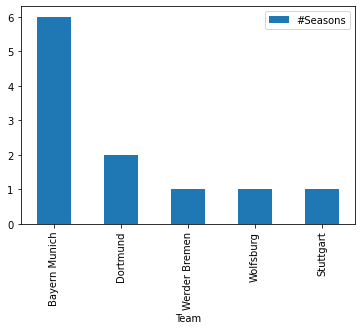

In [12]:
df_D1_winner_of_season.groupby('Team') \
    .agg(count('Team').alias('#Seasons')) \
    .orderBy('#Seasons', ascending=False) \
    .toPandas() \
    .plot.bar(x='Team', y='#Seasons')

### Summary question 1:
- There are D1 winner teams from 2000-2010.
- Bayern Munich is the most successful team that wins 6 of 10 times.

## 2. Which teams have been relegated in the past 10 years?

In [13]:
df_D1_season_summary.show(10)

+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+
|Season|          Team|Wins|Draws|Loses|GoalsFor|GoalsAgainst|GoalsDiff|TotalPointsPerSeason|Position|
+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+
|  1993| Bayern Munich|  17|   10|    7|      68|          37|       31|                  61|       1|
|  1993|Kaiserslautern|  18|    7|    9|      64|          36|       28|                  61|       2|
|  1993|      Dortmund|  15|    9|   10|      49|          45|        4|                  54|       3|
|  1993| Ein Frankfurt|  15|    8|   11|      57|          41|       16|                  53|       4|
|  1993|    Leverkusen|  14|   11|    9|      60|          47|       13|                  53|       5|
|  1993|     Karlsruhe|  14|   10|   10|      46|          43|        3|                  52|       6|
|  1993|     Stuttgart|  13|   11|   10|      51|          43|        8| 

In [14]:
df_relegated_teams = df_D1_season_summary.filter(
        (df_D1_season_summary['Season'] >= '2000') &
        (df_D1_season_summary['Season'] <= '2010') &
        (df_D1_season_summary['Position'].between(16, 18)) 
    )

df_relegated_teams.show(33)

+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+
|Season|          Team|Wins|Draws|Loses|GoalsFor|GoalsAgainst|GoalsDiff|TotalPointsPerSeason|Position|
+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+
|  2000|  Unterhaching|   8|   11|   15|      35|          59|      -24|                  35|      16|
|  2000| Ein Frankfurt|  10|    5|   19|      41|          68|      -27|                  35|      17|
|  2000|        Bochum|   7|    6|   21|      30|          67|      -37|                  27|      18|
|  2001|      Freiburg|   7|    9|   18|      37|          64|      -27|                  30|      16|
|  2001|       FC Koln|   7|    8|   19|      26|          61|      -35|                  29|      17|
|  2001|      St Pauli|   4|   10|   20|      37|          70|      -33|                  22|      18|
|  2002|     Bielefeld|   8|   12|   14|      35|          46|      -11| 

## 3. What's the best month to watch Bundesliga? (based on last 10 seasons)

In [15]:
df_matches.filter(df_matches['Div'] == 'D1').show(10)

+--------+---+------+----------+-------------+----------+---------+---------+-----------+
|Match_ID|Div|Season|      Date|     HomeTeam|  AwayTeam|HomeGoals|AwayGoals|MatchResult|
+--------+---+------+----------+-------------+----------+---------+---------+-----------+
|      21| D1|  2009|2010-02-06|       Bochum|Leverkusen|        1|        1|          D|
|      22| D1|  2009|2009-11-22|Bayern Munich|Leverkusen|        1|        1|          D|
|      23| D1|  2009|2010-05-08|   M'gladbach|Leverkusen|        1|        1|          D|
|      24| D1|  2009|2009-08-08|        Mainz|Leverkusen|        2|        2|          D|
|      25| D1|  2009|2009-10-17|      Hamburg|Leverkusen|        0|        0|          D|
|      26| D1|  2009|2010-04-17|    Stuttgart|Leverkusen|        2|        1|          H|
|      27| D1|  2009|2010-03-20|     Dortmund|Leverkusen|        3|        0|          H|
|      28| D1|  2009|2009-10-31|   Schalke 04|Leverkusen|        2|        2|          D|
|      29|

In [16]:
error_seasons = df_matches.filter((df_matches['Div']=='D1') & ((df_matches['HomeGoals']<0) | (df_matches['AwayGoals']<0))) \
                    .select('Season') \
                    .distinct() \
                    .collect()

error_seasons = list(error_seasons[0])

In [17]:
last_10_seasons = list(
    df_matches \
    .select('Season') \
    .distinct() \
    .sort(df_matches.Season.desc()) \
    .filter(~df_matches['Season'].isin(error_seasons)) \
    .limit(10) \
    .toPandas()['Season']
)

In [18]:
df_goal_avg = df_matches.filter((df_matches['Div'] == 'D1') & (df_matches['Season'].isin(last_10_seasons))) \
    .groupby(df_matches['Date'][6:2].alias('Month')) \
    .agg(
            (sum('HomeGoals')+sum('AwayGoals')).alias('GoalCount'),
            count('Match_ID').alias('MatchCount')
        ) \
    .sort('Month')

df_goal_avg = df_goal_avg.withColumn('GoalsPerMatch', df_goal_avg['GoalCount'] / df_goal_avg['MatchCount'])

df_goal_avg.show()

+-----+---------+----------+------------------+
|Month|GoalCount|MatchCount|     GoalsPerMatch|
+-----+---------+----------+------------------+
|   01|      403|       151|2.6688741721854305|
|   02|     1025|       369|2.7777777777777777|
|   03|     1044|       362| 2.883977900552486|
|   04|     1151|       405|2.8419753086419752|
|   05|      802|       253|3.1699604743083003|
|   08|      700|       243| 2.880658436213992|
|   09|     1021|       343|2.9766763848396502|
|   10|      906|       321| 2.822429906542056|
|   11|     1022|       334| 3.059880239520958|
|   12|      766|       279|2.7455197132616487|
+-----+---------+----------+------------------+



<AxesSubplot:xlabel='Month'>

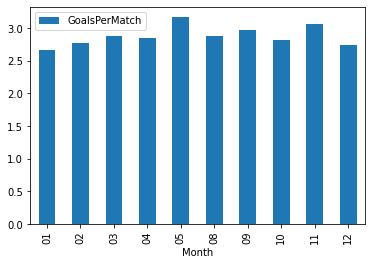

In [19]:
df_goal_avg.toPandas().plot.bar(x='Month', y='GoalsPerMatch')

### Summary question 3
- The best month to watch Bundesliga is May which is almost the end of the season.

## 4. Does Octoberfest affect the performance of Bundesliga?

In [20]:
windowSpec2  = Window.orderBy(df_goal_avg['GoalsPerMatch'].desc())

df_goal_avg.withColumn('Rank', rank().over(windowSpec2)).show()

+-----+---------+----------+------------------+----+
|Month|GoalCount|MatchCount|     GoalsPerMatch|Rank|
+-----+---------+----------+------------------+----+
|   05|      802|       253|3.1699604743083003|   1|
|   11|     1022|       334| 3.059880239520958|   2|
|   09|     1021|       343|2.9766763848396502|   3|
|   03|     1044|       362| 2.883977900552486|   4|
|   08|      700|       243| 2.880658436213992|   5|
|   04|     1151|       405|2.8419753086419752|   6|
|   10|      906|       321| 2.822429906542056|   7|
|   02|     1025|       369|2.7777777777777777|   8|
|   12|      766|       279|2.7455197132616487|   9|
|   01|      403|       151|2.6688741721854305|  10|
+-----+---------+----------+------------------+----+



### Summary question 4
- Oktoberfest affect, because goals/match is at 7 of 10 positions.
- From the graph above (question 3), goals/match in October is less than the 2 nearest months.

## 5. Which season of Bundesliga was the most competitive in the last decade?

In [21]:
df_D1_season_summary.filter(
        (df_D1_season_summary['Season'] >= '2000') &
        (df_D1_season_summary['Season'] <= '2010')
    ).show(10)

+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+
|Season|          Team|Wins|Draws|Loses|GoalsFor|GoalsAgainst|GoalsDiff|TotalPointsPerSeason|Position|
+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+
|  2000| Bayern Munich|  19|    6|    9|      62|          37|       25|                  63|       1|
|  2000|    Schalke 04|  18|    8|    8|      65|          35|       30|                  62|       2|
|  2000|      Dortmund|  16|   10|    8|      62|          42|       20|                  58|       3|
|  2000|    Leverkusen|  17|    6|   11|      54|          40|       14|                  57|       4|
|  2000|        Hertha|  18|    2|   14|      58|          52|        6|                  56|       5|
|  2000|      Freiburg|  15|   10|    9|      54|          37|       17|                  55|       6|
|  2000| Werder Bremen|  15|    8|   11|      53|          48|        5| 

In [22]:
w = Window.partitionBy('Season').orderBy('Position')

df_diff_points = df_D1_season_summary.filter(
                                                (df_D1_season_summary['Season'] >= '2000') &
                                                (df_D1_season_summary['Season'] <= '2010')
                                            ) \
                                            .withColumn('LowerAdjacentPoints', lead('TotalPointsPerSeason', 1).over(w))

df_diff_points = df_diff_points.withColumn(
                                            'AdjacentPointDiff',
                                            when(
                                                  df_diff_points['LowerAdjacentPoints'].isNotNull(),
                                                  df_diff_points['TotalPointsPerSeason']-df_diff_points['LowerAdjacentPoints']
                                            ) \
                                            .otherwise(0)
                                         )

df_diff_points.show()

+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+-------------------+-----------------+
|Season|          Team|Wins|Draws|Loses|GoalsFor|GoalsAgainst|GoalsDiff|TotalPointsPerSeason|Position|LowerAdjacentPoints|AdjacentPointDiff|
+------+--------------+----+-----+-----+--------+------------+---------+--------------------+--------+-------------------+-----------------+
|  2000| Bayern Munich|  19|    6|    9|      62|          37|       25|                  63|       1|                 62|                1|
|  2000|    Schalke 04|  18|    8|    8|      65|          35|       30|                  62|       2|                 58|                4|
|  2000|      Dortmund|  16|   10|    8|      62|          42|       20|                  58|       3|                 57|                1|
|  2000|    Leverkusen|  17|    6|   11|      54|          40|       14|                  57|       4|                 56|                1|
|  2000|     

<AxesSubplot:xlabel='Season'>

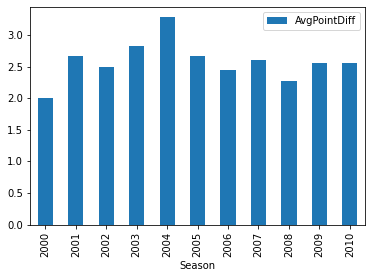

In [23]:
df_diff_points.groupby('Season').agg(avg('AdjacentPointDiff').alias('AvgPointDiff')).toPandas().plot.bar(x='Season', y='AvgPointDiff')

### Summary question 5
- 2000/01 season is the most competitive season, since the average of point difference of nearest position is lowest.